In [1]:
from keras.datasets import imdb

In [2]:
(X_train,y_train),(X_test,y_test) = imdb.load_data("/tmp/imbd.npz",num_words=20000,skip_top=0,maxlen=80,start_char=1,oov_char=2,index_from=3)

17465344/17464789 [==============================] - 1s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/rajagopal/mlenv/lib/python3.6/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/Users/rajagopal/mlenv/lib/python3.6/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do

In [3]:
idx=imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


In [4]:
idx

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

In [6]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM

In [13]:
maxlen=80
X_train_pad= pad_sequences(X_train,maxlen=maxlen)
X_test_pad= pad_sequences(X_test,maxlen=maxlen)

In [15]:
X_test_pad.shape

(2021, 80)

In [14]:
max_features = max([max(x) for x in X_train_pad]+ [max(x) for x in X_test_pad])

In [29]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
inputs = Input(shape=(maxlen,))
h = Embedding(input_dim=max_features+1, output_dim=128)(inputs)
h = LSTM(64,dropout=0.2,recurrent_dropout=0.2)(h)
outputs = Dense(1, activation='sigmoid')(h)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 80, 128)           2559360   
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 2,608,833
Trainable params: 2,608,833
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.fit(X_train_pad,y_train,batch_size=32,epochs=3,validation_split=0.3)

Epoch 1/3
41/41 [==============================] - 5s 90ms/step - loss: 0.6832 - accuracy: 0.5722 - val_loss: 0.5911 - val_accuracy: 0.6482
Epoch 2/3
41/41 [==============================] - 3s 85ms/step - loss: 0.4769 - accuracy: 0.8227 - val_loss: 0.4974 - val_accuracy: 0.8000
Epoch 3/3
41/41 [==============================] - 3s 86ms/step - loss: 0.1707 - accuracy: 0.9524 - val_loss: 0.4070 - val_accuracy: 0.8250


In [31]:
score,acc = model.evaluate(X_test_pad,y_test)
print('Test Score',score)
print('Test Acc',acc)

64/64 [==============================] - 0s 6ms/step - loss: 0.4255 - accuracy: 0.8144
Test Score 0.4254944324493408
Test Acc 0.8144482970237732


In [36]:
from sklearn.datasets import load_digits
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
import tensorflow.keras.backend as K
import numpy as np

In [33]:
digits = load_digits()
X, y = digits.data, digits.target
y_cat = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.3)


In [49]:
def repeated_training_reg_dropout(X_train,
                                  y_train,
                                  X_test,
                                  y_test,
                                  units=512,
                                  activation='sigmoid',
                                  optimizer='sgd',
                                  do_dropout=False,
                                  rate=0.3,
                                  kernel_regularizer='l2',
                                  epochs=10,
                                  repeats=3):
    histories = []
    
    for repeat in range(repeats):
        K.clear_session()
        
        inputs = Input(shape=X_train.shape[1:])
        h = Dense(units,
                        input_shape=X_train.shape[1:],
                        kernel_initializer='normal',
                        kernel_regularizer=kernel_regularizer,
                        activation=activation)(inputs)

        if do_dropout:
            h = Dropout(rate)(h)

        h = Dense(units,
                  kernel_initializer='normal',
                  kernel_regularizer=kernel_regularizer,
                  activation=activation)(h)
    
        if do_dropout:
            h = Dropout(rate)(h)

        # third fully connected layer
        h =Dense(units,
                        kernel_initializer='normal',
                        kernel_regularizer=kernel_regularizer,
                        activation=activation)(h)
        if do_dropout:
            h = Dropout(rate)(h)

        # output layer
        outputs = Dense(10, activation='softmax')(h)
        model = Model(inputs=inputs, outputs=outputs)
        
        
        model.compile(optimizer,
                      'categorical_crossentropy',
                      metrics=['accuracy'])

        h = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0)
        histories.append([h.history['accuracy'], h.history['val_accuracy']])
        print(repeat, end=' ')

    histories = np.array(histories)
    
    # calculate mean and standard deviation across repeats:
    mean_acc = histories.mean(axis=0)
    std_acc = histories.std(axis=0)
    print()
    
    return mean_acc[0], std_acc[0], mean_acc[1], std_acc[1]

In [50]:
mean_acc, std_acc, mean_acc_val, std_acc_val = repeated_training_reg_dropout(X_train,
                                                                             y_train,
                                                                             X_test,
                                                                             y_test,
                                                                             do_dropout=False)


0 1 2 


In [51]:
mean_acc_do, std_acc_do, mean_acc_val_do, std_acc_val_do = repeated_training_reg_dropout(X_train,
                                                                                         y_train,
                                                                                         X_test,
                                                                                         y_test,
                                                                                         do_dropout=True)

0 1 2 


In [52]:
import matplotlib.pyplot as plt
def plot_mean_std(m, s):
    plt.plot(m)
    plt.fill_between(range(len(m)), m-s, m+s, alpha=0.1)

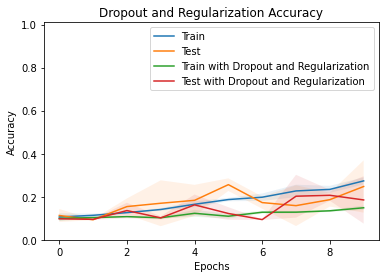

In [53]:
plot_mean_std(mean_acc, std_acc)
plot_mean_std(mean_acc_val, std_acc_val)
plot_mean_std(mean_acc_do, std_acc_do)
plot_mean_std(mean_acc_val_do, std_acc_val_do)
plt.ylim(0, 1.01)
plt.title("Dropout and Regularization Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test', 'Train with Dropout and Regularization', 'Test with Dropout and Regularization'], loc='best')


In [54]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from itertools import islice
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [67]:
K.clear_session()
inputs = Input(shape= (64,64,3,))
h = Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu')(inputs)
h = MaxPooling2D(pool_size = (2, 2))(h)
h = BatchNormalization()(h)

h=Conv2D(64, (3, 3), activation = 'relu')(h)
h=MaxPooling2D(pool_size = (2, 2))(h)
h=BatchNormalization()(h)

h=Conv2D(64, (3, 3), activation = 'relu')(h)
h=MaxPooling2D(pool_size = (2, 2))(h)
h=BatchNormalization()(h)

h=Flatten()(h)

h=Dense(128, activation = 'relu')(h)
outputs =Dense(1, activation = 'sigmoid')(h)
model = Model(inputs=inputs, outputs=outputs)

In [68]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 31, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256   

In [69]:
train_gen = ImageDataGenerator(rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rotation_range = 10,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               horizontal_flip = True)

test_gen = ImageDataGenerator(rescale = 1./255)

In [74]:
data_path = './data/male_female/data/'
train = train_gen.flow_from_directory(data_path + '/train',
                                      target_size = (64, 64),
                                      batch_size = 16,
                                      class_mode = 'binary')

test = test_gen.flow_from_directory(data_path + '/test',
                                    target_size = (64, 64),
                                    batch_size = 16,
                                    class_mode = 'binary')

Found 11663 images belonging to 2 classes.
Found 2920 images belonging to 2 classes.


In [75]:
model.fit(train,
          steps_per_epoch = 800,
          epochs = 200,
          validation_data = test,
          validation_steps = 200)

Epoch 1/200
800/800 [==============================] - 108s 135ms/step - loss: 0.7999 - accuracy: 0.6322 - val_loss: 0.5509 - val_accuracy: 0.7110


In [76]:
X_test = []
y_test = []
for ts in islice(test, 50):
    X_test.append(ts[0])
    y_test.append(ts[1])

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

In [78]:
y_pred = model.predict(X_test).ravel()

In [79]:
np.argwhere(y_test != y_pred).ravel()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

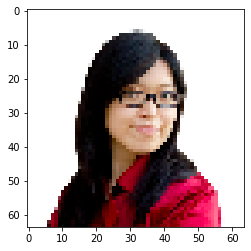

In [80]:
plt.imshow(X_test[14])

In [ ]:
# !aria2c 'https://www.dropbox.com/s/nov493om2jmh2gp/male_female.tgz?dl=1' 
# data_path = './data/male_female'
# !tar -xzvf male_female.tgz --directory {data_path}